Carregando os pacotes necessários:

In [1]:
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import numpy as np

import flwr as fl
import pandas as pd

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
acc_train = []
acc_test = []
loss_train = []
loss_test = []

Carregando o dataset CIFAR-10 (conjuntos de treinamento e teste):

In [2]:
def load_data():
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = CIFAR10(".", train = True, download = True, transform = transform)
    testset = CIFAR10(".", train = False, download = True, transform = transform)
    trainloader = DataLoader(trainset, batch_size = 8, shuffle = True)
    testloader = DataLoader(testset, batch_size = 8)
    return trainloader, testloader

### Redes Neurais

Modelo 1:

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3,
                               padding = 1, 
                               stride = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3,
                               padding = 1)
        self.conv3 = nn.Conv2d(128, 256, 3,
                               padding = 1)
        self.conv4 = nn.Conv2d(256, 512, 3,
                               padding = 1)
        self.fc1 = nn.Linear(256, 10)
        self.bn1 = nn.BatchNorm2d(num_features = 256)
        #self.bn2 = nn.BatchNorm2d(num_features = 512)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.bn1(self.conv3(x))))
        #x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256)
        x = self.fc1(x)
        return x

Modelo 2:

In [4]:
class CNN(nn.Module):
    """Simple CNN adapted"""

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return x

Definindo o no peek loss:

In [5]:
class NoPeekLoss(torch.nn.modules.loss._Loss):
    def __init__(self, dcor_weighting: float = 0.1) -> None:
        super().__init__()
        self.dcor_weighting = dcor_weighting

        self.ce = torch.nn.CrossEntropyLoss()
        self.dcor = DistanceCorrelationLoss()

    def forward(self, inputs, intermediates, outputs, targets):
        loss = self.ce(outputs, targets)

        # DistanceCorrelationLoss is costly, so only calc it if necessary
        if self.dcor_weighting > 0.0:
            loss += self.dcor_weighting * self.dcor(inputs, intermediates)

        return loss

class DistanceCorrelationLoss(torch.nn.modules.loss._Loss):
    def forward(self, input_data, intermediate_data):
        input_data = input_data.view(input_data.size(0), -1)
        intermediate_data = intermediate_data.view(intermediate_data.size(0), -1)

        # Get A matrices of data
        A_input = self._A_matrix(input_data)
        A_intermediate = self._A_matrix(intermediate_data)

        # Get distance variances
        input_dvar = self._distance_variance(A_input)
        intermediate_dvar = self._distance_variance(A_intermediate)

        # Get distance covariance
        dcov = self._distance_covariance(A_input, A_intermediate)

        # Put it together
        dcorr = dcov / (input_dvar * intermediate_dvar).sqrt()

        return dcorr

    def _distance_covariance(self, a_matrix, b_matrix):
        return (a_matrix * b_matrix).sum().sqrt() / a_matrix.size(0)

    def _distance_variance(self, a_matrix):
        return (a_matrix ** 2).sum().sqrt() / a_matrix.size(0)

    def _A_matrix(self, data):
        distance_matrix = self._distance_matrix(data)

        row_mean = distance_matrix.mean(dim=0, keepdim=True)
        col_mean = distance_matrix.mean(dim=1, keepdim=True)
        data_mean = distance_matrix.mean()

        return distance_matrix - row_mean - col_mean + data_mean

    def _distance_matrix(self, data):
        n = data.size(0)
        distance_matrix = torch.zeros((n, n))

        for i in range(n):
            for j in range(n):
                row_diff = data[i] - data[j]
                distance_matrix[i, j] = (row_diff ** 2).sum()

        return distance_matrix

Função de treinamento da rede:

In [6]:
def train(net, trainloader, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    #criterion = NoPeekLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)
    
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training {epochs} epoch(s) w/ {len(trainloader)} mini-batches each")
    
    for epoch in range(epochs):
        print()
        loss_epoch: float = 0.0
        correct: float = 0.0
        num_examples_train: int = 0
        batch_idx: int = 0
        total: int = 0
            
        for images, labels in trainloader:
            
            if batch_idx < len(trainloader)-1:
                images, labels = images.to(DEVICE), labels.to(DEVICE)

                num_examples_train += len(images)
                batch_idx += 1

                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)   
                #intermediate_parameters = []
                #for param in net.parameters():
                #    intermediate_parameters.append(param.view(-1))
                #intermediate_parameters = torch.cat(intermediate_parameters)                    
                #loss = criterion(images, intermediate_parameters, net(images), labels).item() 
                loss.backward()
                optimizer.step()
                loss_epoch += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                if batch_idx % 10 == 8:
                    print(
                        "Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}\t\t\t\t\t\t\t\t".format(
                            epoch,
                            num_examples_train,
                            len(trainloader) * trainloader.batch_size,
                            100.0
                            * num_examples_train
                            / len(trainloader)
                            / trainloader.batch_size,
                            loss.item(),
                        ),
                        end="\r",
                        flush=True,
                    )
            
        loss_train.append(loss.item())
        acc_train.append(correct / total    )

Definindo a função de teste do servidor:

In [7]:
def test(net, testloader):
    criterion = torch.nn.CrossEntropyLoss()
    #criterion = NoPeekLoss()
    correct, total, loss = 0, 0, 0.0
    
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()    
            #intermediate_parameters = []
            #for param in net.parameters():
            #    intermediate_parameters.append(param.view(-1))
            #intermediate_parameters = torch.cat(intermediate_parameters)
            #loss += criterion(images, intermediate_parameters, outputs, labels).item()    
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total    
    acc_test.append(accuracy)
    loss_test.append(loss/len(testloader))
    return loss/len(testloader), accuracy

Definindo a função cliente:

In [8]:
from torchvision import models

class CifarClient(fl.client.NumPyClient):
    def __init__(self, cid, train_loader, test_loader, epochs, device: torch.device = torch.device(DEVICE)):
        self.model = CNN().to(device)   
        
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.epochs = epochs

    def set_parameters(self, parameters):
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)

    def set_weights(self, weights):
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in zip(self.model.state_dict().keys(), weights)})
        self.model.load_state_dict(state_dict, strict = True)
        
    def get_parameters(self) -> fl.common.Weights:
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        #intermediate_parameters  = self.get_weights()
        train(self.model, self.train_loader, epochs = self.epochs)
        return self.get_parameters(), len(self.train_loader), {}

    def evaluate(self, parameters, config):        
        self.set_parameters(parameters)
        loss, accuracy = test(self.model, self.test_loader)  
        return float(loss), len(self.test_loader), {"accuracy":float(accuracy)}

Executando o servidor:

In [9]:
current_client = 1
n_clients = 2
train_batch_size = 32
test_batch_size = 1000
epochs = 10

train_loader, test_loader = load_data()

df = pd.DataFrame(list())
df.to_csv('accuracy_1.csv')
df.to_csv('loss_1.csv')

client = CifarClient(
        cid = current_client,
        train_loader = train_loader,
        test_loader = test_loader,
        epochs = epochs,
        device = DEVICE,
)

fl.client.start_numpy_client("[::]:8081", client = client)

Files already downloaded and verified
Files already downloaded and verified


DEBUG flower 2021-08-19 00:35:38,365 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2021-08-19 00:35:38,367 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2021-08-19 00:35:38,367 | connection.py:36 | ChannelConnectivity.READY


Training 10 epoch(s) w/ 6250 mini-batches each



/home/eduarda/cybersecurity/Cybersecurity-FL/env/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 0 [49984/50000 (100%)] Loss: 1.695956								
Train Epoch: 1 [49984/50000 (100%)] Loss: 1.437064								
Train Epoch: 2 [49984/50000 (100%)] Loss: 1.172724								
Train Epoch: 3 [49984/50000 (100%)] Loss: 1.023627								
Train Epoch: 4 [49984/50000 (100%)] Loss: 0.845999								
Train Epoch: 5 [49984/50000 (100%)] Loss: 0.369855								
Train Epoch: 6 [49984/50000 (100%)] Loss: 0.749806								
Train Epoch: 7 [49984/50000 (100%)] Loss: 0.735465								
Train Epoch: 8 [49984/50000 (100%)] Loss: 0.858635								


DEBUG flower 2021-08-19 00:41:37,699 | connection.py:68 | Insecure gRPC channel closed
INFO flower 2021-08-19 00:41:37,701 | app.py:72 | Disconnect and shut down


In [10]:
print("Accuracy Test", acc_test)
print("Loss Train", loss_train)
print("Loss Test", loss_test)

Accuracy Test [0.625]
Loss Train [1.3297196626663208, 1.3802931308746338, 0.9306198358535767, 0.7025516033172607, 0.46194714307785034, 1.4692999124526978, 0.5690845251083374, 1.095055103302002, 1.0340639352798462, 0.5718330144882202]
Loss Test [1.0724758597373962]


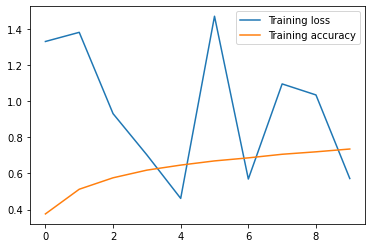

In [11]:
import matplotlib.pyplot as plt
 
plt.plot(range(len(loss_train)), loss_train, label = 'Training loss')
plt.plot(range(len(acc_train)), acc_train, label = 'Training accuracy')
plt.legend()

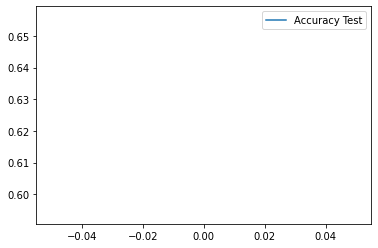

In [12]:
plt.plot(range(len(acc_test)), acc_test, label = 'Accuracy Test')
plt.legend()